In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, timedelta

import tsfresh
import logging
logging.getLogger('tsfresh').setLevel(logging.ERROR)

from tsfresh import defaults, extract_features, select_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame, impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import ComprehensiveFCParameters

matplotlib.rcParams["figure.figsize"] = [16, 6]
matplotlib.rcParams["font.size"] = 14
matplotlib.style.use('seaborn-darkgrid')

from IPython.display import Image, IFrame

import warnings
warnings.filterwarnings('ignore')

### Introduction ####

In this notebook we will illustrate use of tsfresh for time series feature extraction and feature filtering using a subset of the project training data.

The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building your models.

File Name: train.csv

- Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
- The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
Negative values of unit_sales represent returns of that particular item.
- The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
- Approximately 16% of the onpromotion values in this file are NaN.
- NOTE: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

In [4]:
df_train = pd.read_csv(
    '../data/raw/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    parse_dates=["date"],
    skiprows=range(1, 36458909) 
)

In [5]:
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2014-12-02,10,464336,4.0,False
1,2014-12-02,10,464339,5.0,False
2,2014-12-02,10,464374,4.0,False
3,2014-12-02,10,464906,1.0,False
4,2014-12-02,10,464940,7.0,False


In [6]:
df_train.dtypes

date           datetime64[ns]
store_nbr               int64
item_nbr                int64
unit_sales            float64
onpromotion              bool
dtype: object

In [7]:
df_train_wide = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_train_wide.columns = df_train_wide.columns.get_level_values(1)
df_train_wide.head()

date                2014-12-02  2014-12-03  2014-12-04  2014-12-05  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         2.0         3.0   
          105574           0.0         7.0         4.0         3.0   

date                2014-12-06  2014-12-07  2014-12-08  2014-12-09  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         2.0   
          103665           4.0         2.0         3.0         3.0   
          105574           3.0         1.0        27.0         3.0   

date                2014-12-10  2014-12-11     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995            0.0         0.0     ...             2.0   
          99197            0.0         0.0     ...             0.0   
          103520           8.0         5.0     ...             0.0   
          103665           0.0         4.0     ...             1.0   
          105574          23.0         3.0     ...             0.0   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995            2.0         0.0         0.0         1.0   
          99197            2.0         0.0         2.0         0.0   
          103520           0.0         3.0         0.0         3.0   
          103665           2.0         0.0         7.0         9.0   
          105574           5.0         7.0         6.0        10.0   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995            0.0         0.0         0.0         0.0         0.0  
          99197            0.0         0.0         0.0         0.0         0.0  
          103520           1.0         1.0         1.0         0.0         0.0  
          103665           2.0         0.0         0.0         1.0         1.0  
          105574           5.0         5.0         0.0         3.0         4.0  

[5 rows x 985 columns]

### time series data for a store,item ###


Top 2 stores by sales:  44, 45
Considering time series of store 44, Item 1503823

In [8]:
df_item = df_train_wide.loc[(44, 1503823), :]
df_item_sales = pd.DataFrame({'date':df_item.index, 'unit_sales':df_item.values})
df_item_sales['store_item'] = "44_1503823"
df_item_sales.set_index("date", inplace = True) 
df_item_sales.head()

,unit_sales,store_item
date,,
2014-12-02,19.191,44_1503823
2014-12-03,28.612,44_1503823
2014-12-04,13.072,44_1503823
2014-12-05,10.053,44_1503823
2014-12-06,29.296,44_1503823


In [9]:
df_shift, y = make_forecasting_frame(df_item_sales["unit_sales"], kind="sales", max_timeshift=15, rolling_direction=1)


### Extract Features ###

tsfresh calculates a comprehensive number of features. All feature calculators are contained in the
tsfresh.feature_extraction.feature_calculators - This module contains the feature calculators that take time
series as input and calculate the values of the feature.

some sample extracted features:

ar_coefficient(x, param) -  This feature calculator fits the unconditional maximum likelihood of an autoregressive AR(k) process.

augmented_dickey_fuller(x, param) - The Augmented Dickey-Fuller test is a hypothesis test which checks whether a unit root is present in a time series sample

autocorrelation(x, lag) - Calculates the autocorrelation of the specified lag

agg_linear_trend(x, param) Calculates a linear least-squares regression for values of the
time series that were aggregated over chunks versus the sequence from 0 up to the number of chunks minus one.

approximate_entropy(x, m, r) Implements a vectorized Approximate entropy algorithm.

#### tsfresh.feature_extraction.extraction module ####

This module contains the main function to interact with tsfresh: extract features

Extract features from

• a pandas.DataFrame containing the different time series
or

• a dictionary of pandas.DataFrame each containing one type of time series

In both cases a pandas.DataFrame with the calculated features will be returned.
For a list of all the calculated time series features, please see the ComprehensiveFCParameters class,
which is used to control which features with which parameters are calculated


#### Feature extraction settings ####
When starting a new data science project involving time series you probably want to start by extracting a comprehensive set of features. Later you can identify which features are relevant for the task at hand. In the final stages, you
probably want to fine tune the parameter of the features to fine tune your models.
You can do all those things with tsfresh.

In [12]:
extraction_settings = ComprehensiveFCParameters()

In [13]:
X = extract_features(df_shift, 
                     column_id="id", 
                     column_sort="time", 
                     column_value="value", 
                     default_fc_parameters=extraction_settings,
                     impute_function=impute,
                     show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


In [14]:
print(X.info)
print(X.head)

<bound method DataFrame.info of variable    value__abs_energy  value__absolute_sum_of_changes  \
id                                                              
2014-12-03         368.294481                           0.000   
2014-12-04        1186.941025                           9.421   
2014-12-05        1357.818209                          24.961   
2014-12-06        1458.881018                          27.980   
2014-12-07        2317.136634                          47.223   
2014-12-08        3405.278803                          50.914   
2014-12-09        3659.394284                          67.960   
2014-12-10        4171.873328                          74.657   
2014-12-11        5786.145012                          92.197   
2014-12-12        5863.637821                         123.572   
2014-12-13        6036.928717                         127.933   
2014-12-14        6516.582518                         136.670   
2014-12-15        7046.502918                         137.

### Parameter setting ###

fdr_level (float) – The FDR level that should be respected, this is the theoretical
expected percentage of irrelevant features among all created feature

hypotheses_independent (bool) – Can the significance of the features be assumed
to be independent? Normally, this should be set to False as the features are never independent (e.g. mean and median)

In [15]:
FDR_LEVEL = defaults.FDR_LEVEL
HYPOTHESES_INDEPENDENT = defaults.HYPOTHESES_INDEPENDENT

In [16]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(984, 794)
(984, 341)


### Feature filtering ###

The all-relevant problem of feature selection is the identification of all strongly and weakly relevant attributes. 


To limit the number of irrelevant features, tsfresh deploys the fresh algorithm (fresh stands for FeatuRe Extraction
based on Scalable Hypothesis tests)


The algorithm is called by tsfresh.feature_selection.relevance.
calculate_relevance_table(). It is an efficient, scalable feature extraction algorithm, which filters
the available features in an early stage of the machine learning pipeline with respect to their significance for the
classification or regression task, while controlling the expected percentage of selected but irrelevant features.

The filtering process consists of three phases which are sketched in the following figure:

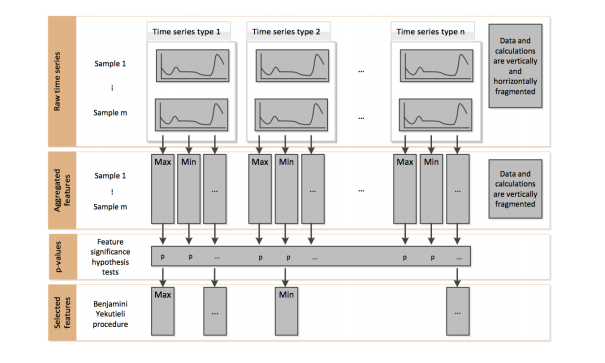

In [17]:
Image(filename='../img/feature_filtering.png')

#### Phase 1 - Feature extraction ####

Firstly, the algorithm characterizes time series with comprehensive and well-established feature mappings and considers additional features describing meta-information. The feature calculators used to derive the features are contained
in tsfresh.feature_extraction.feature_calculators.
In the figure from above, this corresponds to the change from raw time series to aggregated features.

#### Phase 2 - Feature significance testing ####

In a second step, each feature vector is individually and independently evaluated with respect to its significance for predicting the target under investigation. Those tests are contained in the submodule tsfresh.
feature_selection.significance_tests. The result of these tests is a vector of p-values, quantifying
the significance of each feature for predicting the label/target.

In the figure from above, this corresponds to the change from aggregated features to p-values

#### Phase 3 - Multiple test procedure ####

The vector of p-values is evaluated on basis of the Benjamini-Yekutieli procedure
in order to decide which features to keep. This multiple testing procedure is contained in the submodule tsfresh.feature_selection.benjamini_hochberg_test.

In the figure from above, this corresponds to the change from p-values to selected features

### Calculate p-values and Benjamini-Yekutieli Procedure ###
tsfresh has implemented different feature significance tests. In the following, one of the tests will be illustrated to show a scientific report of the feature selection process.

### kendall ###
Run significance test with kendall test. Returns the p-values of the features and whether they are rejected or not.

#### tsfresh.feature_selection.relevance module ####

Contains a feature selection method that evaluates the importance of the different extracted features. To do so, for
every feature the influence on the target is evaluated by an univariate tests and the p-Value is calculated. The methods
that calculate the p-values are called feature selectors.

Afterwards the Benjamini Hochberg procedure which is a multiple testing procedure decides which features to keep
and which to cut off (solely based on the p-values).


#### tsfresh.feature_selection.relevance.calculate_relevance_table ####

Calculate the relevance table for the features contained in feature matrix X with respect to target vector y. The
relevance table is calculated for the intended machine learning task ml_task.

To accomplish this for each feature from the input pandas.DataFrame an univariate feature significance test is
conducted. Those tests generate p values that are then evaluated by the Benjamini Hochberg procedure to decide
which features to keep and which to delete.

We are testing

𝐻0 = the Feature is not relevant and should not be added against

𝐻1 = the Feature is relevant and should be kept 

or in other words

𝐻0 = Target and Feature are independent / the Feature has no influence on the target

𝐻1 = Target and Feature are associated / dependent

In [18]:
df_pvalues_kendall = calculate_relevance_table(X, y, ml_task='regression', fdr_level=FDR_LEVEL, test_for_real_target_real_feature='kendall')

In [19]:
print("# total \t", len(df_pvalues_kendall))
print("# relevant \t", (df_pvalues_kendall["relevant"] == True).sum())
print("# irrelevant \t", (df_pvalues_kendall["relevant"] == False).sum(),
      "( # constant", (df_pvalues_kendall["type"] == "const").sum(), ")")

# total 	 341
# relevant 	 257
# irrelevant 	 84 ( # constant 0 )


In [20]:
df_pvalues_kendall.head()

,feature,type,p_value,relevant
feature,,,,
"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)...",real,8.324436e-115,True
"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)...",real,1.030347e-111,True
"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20","value__cwt_coefficients__widths_(2, 5, 10, 20)...",real,6.824719e-109,True
"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_20","value__cwt_coefficients__widths_(2, 5, 10, 20)...",real,1.560991e-108,True
"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_20","value__cwt_coefficients__widths_(2, 5, 10, 20)...",real,6.984948e-108,True


### Calculate rejection line ###

With the rejection line it is determined whether a feature is relevant or irrelevant.

### Kendall’s tau ###

In [21]:
m = len(df_pvalues_kendall.loc[~(df_pvalues_kendall.type == "const")])
K = list(range(1, m + 1))

if HYPOTHESES_INDEPENDENT:
    C = [1] * m
else:
    C = [sum([1.0 / i for i in range(1, k + 1)]) for k in K]

rejection_line_kendall = [FDR_LEVEL * k / m * 1.0 / c for k, c in zip(K, C)]

#### Plot ordered p-values and rejection line ####

In the plot, the p-values are ordered from low to high. Constant features (green points) are always irrelevant but are not considered for calculating the rejection line (red line).

For nice plotting, the p-values are divided in the three groups relevant, irrelevant and constant (which are also irrelevant).

[]

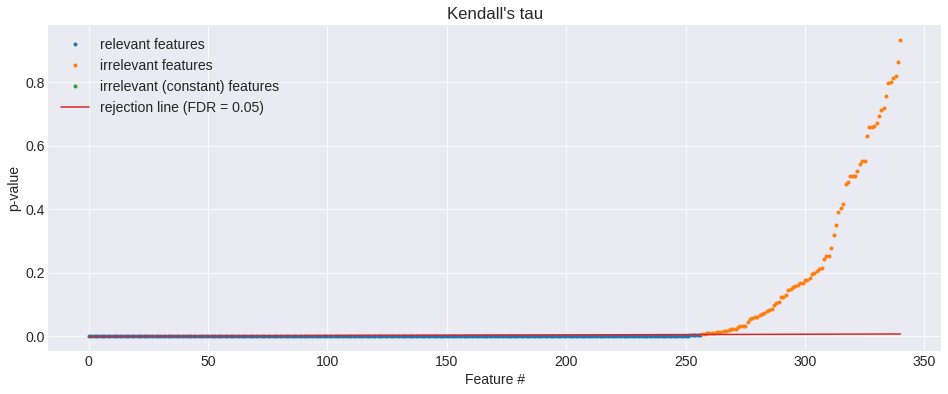

In [22]:
df_pvalues_kendall.index = pd.Series(range(0, len(df_pvalues_kendall.index)))

df_pvalues_kendall.p_value.where(df_pvalues_kendall.relevant)\
    .plot(style=".", label="relevant features")

df_pvalues_kendall.p_value.where(~df_pvalues_kendall.relevant & (df_pvalues_kendall.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_kendall.p_value.fillna(1).where(df_pvalues_kendall.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.plot(rejection_line_kendall, label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Kendall's tau")
plt.legend()
plt.plot()

#### Plot zoomed ordered p-values and rejection line ####

Since the intersection of the ordered p-values and the rejection line is not clearly visible, a zoomed plot is provided.

[]

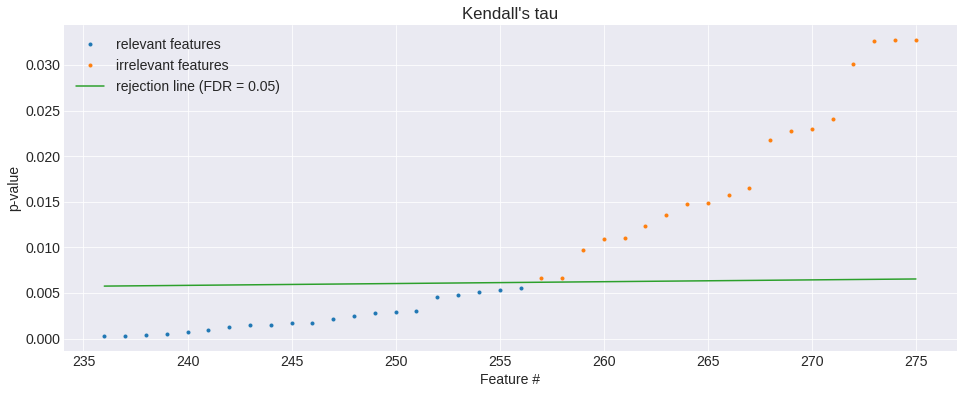

In [23]:
last_rejected_index = (df_pvalues_kendall["relevant"] == True).sum() - 1
margin = 20
a = max(last_rejected_index - margin, 0)
b = min(last_rejected_index + margin, len(df_pvalues_kendall) - 1)

df_pvalues_kendall[a:b].p_value.where(df_pvalues_kendall[a:b].relevant)\
    .plot(style=".", label="relevant features")
df_pvalues_kendall[a:b].p_value.where(~df_pvalues_kendall[a:b].relevant)\
    .plot(style=".", label="irrelevant features")
plt.plot(np.arange(a, b), rejection_line_kendall[a:b], label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Kendall's tau")
plt.legend()
plt.plot()

### References ###

Christ, Kempa-Liehr, Feindt: Distributed and parallel time series feature extraction for industrial big data applications (https://arxiv.org/pdf/1610.07717.pdf)


https://tsfresh.readthedocs.io/en/latest/